In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid', palette = 'deep', color_codes = True)
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [58]:
data = pd.read_csv('apple_stock.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845047,148158800
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075394,365248800
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530056,234428400
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.450966,219111200
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.126770,164101200


In [60]:
# # --------------------- Preprocess the data -----------------------
def preprocess(data, response_variable, time_variable):
    pre_data = data[[time_variable, response_variable]]
    pre_data[time_variable] = pd.to_datetime(pre_data[time_variable])
    pre_data = pre_data.sort_values(by = time_variable, ascending = True)
    pre_data.set_index(time_variable, inplace = True)
    # pre_data = pre_data.resample('D').mean().round(0)
    return pre_data

df = preprocess(data, 'Close', 'Date')
df

,Close
Date,
2019-01-02,39.480000
2019-01-03,35.547501
2019-01-04,37.064999
2019-01-07,36.982498
2019-01-08,37.687500
...,...
2024-01-25,194.169998
2024-01-26,192.419998
2024-01-29,191.729996


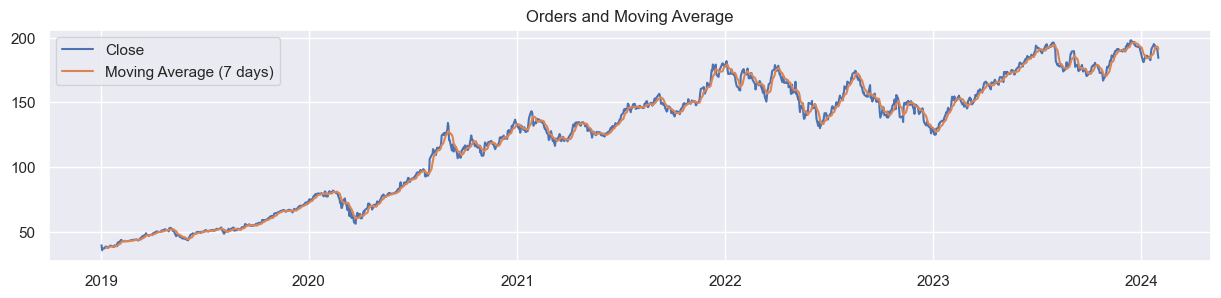

In [62]:
# ------ Plot showing the response variable and its moving average ----------------
def plotter(data, response, titles, windows):
    window_size = windows  # Define the window size for the moving average
    data['Moving Average'] = data[response].rolling(window=window_size).mean()

    # Plot the orders data and the moving average
    plt.figure(figsize=(15, 3))  # Adjust the figure size as desired
    plt.plot(data.index, data[response], label= response)
    plt.plot(data.index, data['Moving Average'], label=f'Moving Average ({window_size} days)')
    plt.title(titles)
    plt.legend()

plotter(df, 'Close', 'Orders and Moving Average', 7)

In [63]:
df

,Close,Moving Average
Date,,
2019-01-02,39.480000,NaN
2019-01-03,35.547501,NaN
2019-01-04,37.064999,NaN
2019-01-07,36.982498,NaN
2019-01-08,37.687500,NaN
...,...,...
2024-01-25,194.169998,191.515712
2024-01-26,192.419998,192.907142
2024-01-29,191.729996,193.349997


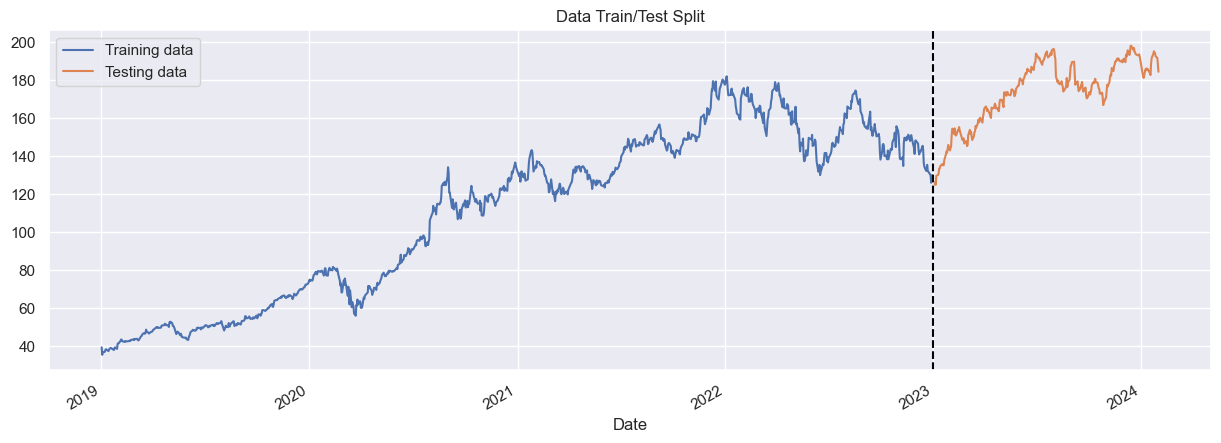

In [61]:
train = df.loc[df.index < '01-01-2023']
test = df.loc[df.index >= '01-01-2023']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label= 'Training data', title = 'Data Train/Test Split')
test.plot(ax=ax, label = 'Testing data')
ax.axvline('01-01-2023', color= 'black', ls='--')
ax.legend(['Training data', 'Testing data'])
plt.show()

In [64]:
new_data = df.copy()

In [73]:
# Create features for the forecast horizon
def add_extra_features(data):
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['weekOfYear'] = data.index.isocalendar().week.astype(int)
    data['dayOfWeek'] = data.index.dayofweek
    data['dayOfMonth'] = data.index.day
    data['dayOfYear'] = data.index.dayofyear
    data['quarter'] = data.index.quarter

    return data

new_data = add_extra_features(data = new_data[['Close']])
new_data

,Close,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter
Date,,,,,,,,
2019-01-02,39.480000,1,2019,1,2,2,2,1
2019-01-03,35.547501,1,2019,1,3,3,3,1
2019-01-04,37.064999,1,2019,1,4,4,4,1
2019-01-07,36.982498,1,2019,2,0,7,7,1
2019-01-08,37.687500,1,2019,2,1,8,8,1
...,...,...,...,...,...,...,...,...
2024-01-25,194.169998,1,2024,4,3,25,25,1
2024-01-26,192.419998,1,2024,4,4,26,26,1
2024-01-29,191.729996,1,2024,5,0,29,29,1


Text(0.5, 1.0, 'Sales By Week Of The Year')

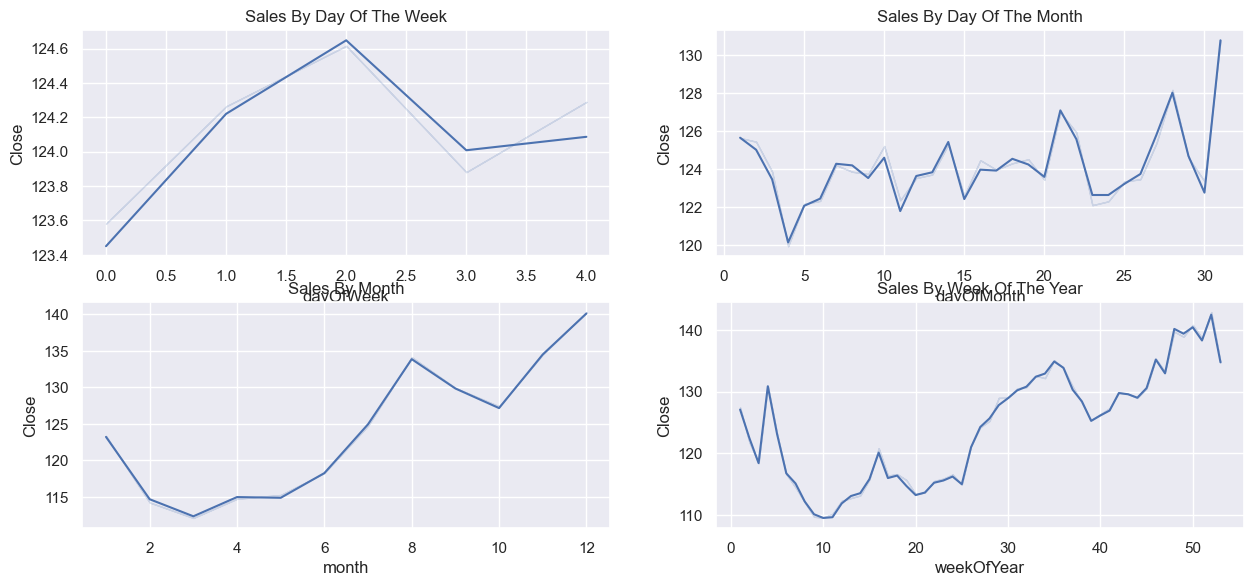

In [15]:
# Show the weekly movt of sales
plt.figure(figsize=(15, 10))
plt.subplot(3,2,1)
sns.lineplot(x = new_data.dayOfWeek, y = new_data.Close, ci = 0, estimator= 'mean')
plt.title('Sales By Day Of The Week')
plt.subplot(3,2,2)
sns.lineplot(x = new_data.dayOfMonth, y = new_data.Close, ci = 0, estimator= 'mean')
plt.title('Sales By Day Of The Month')
plt.subplot(3,2,3)
sns.lineplot(x = new_data.month, y = new_data.Close, ci = 0, estimator= 'mean')
plt.title('Sales By Month')
plt.subplot(3,2,4)
sns.lineplot(x = new_data.weekOfYear, y = new_data.Close, ci = 0, estimator= 'mean')
plt.title('Sales By Week Of The Year')

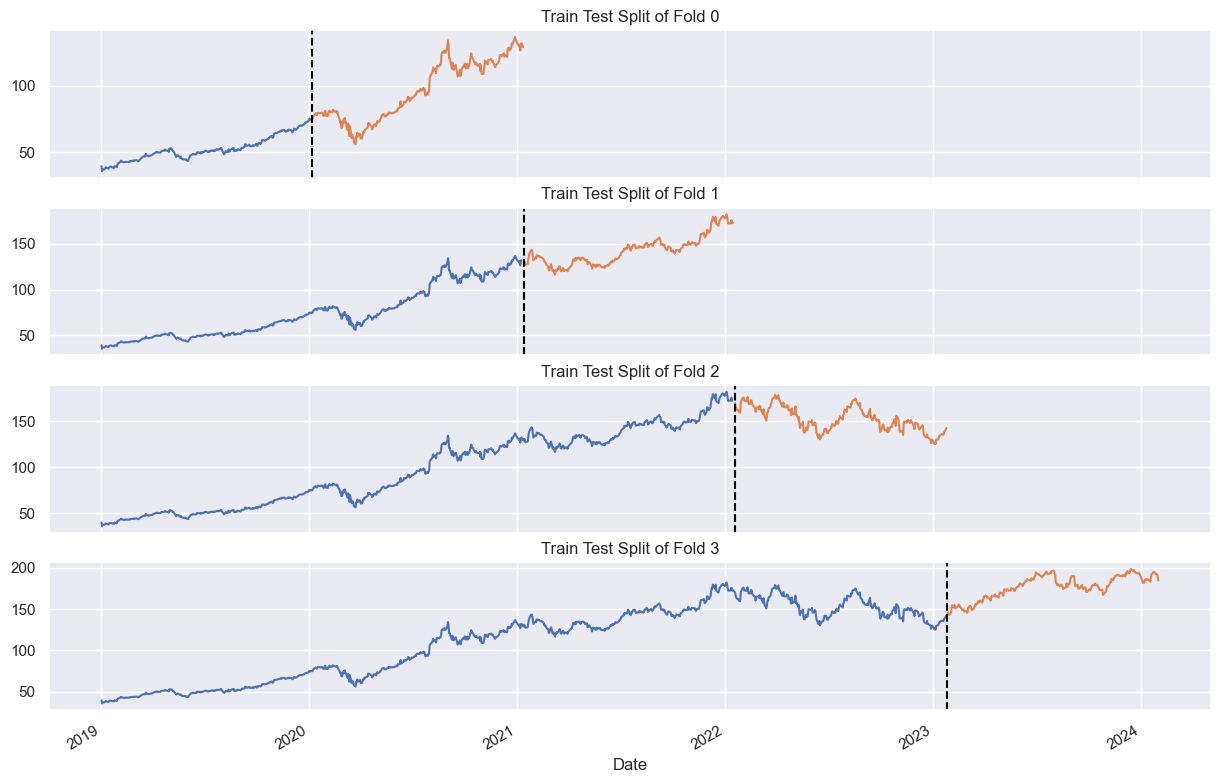

In [74]:
from sklearn.model_selection import TimeSeriesSplit
timeSplit = TimeSeriesSplit(n_splits = 4, test_size = 256, gap = 1)

fold = 0

fig, axs = plt.subplots(4,1, figsize = (15,10), sharex = True)

for index_of_train, index_of_val in timeSplit.split(new_data):
    train = new_data.iloc[index_of_train]
    test = new_data.iloc[index_of_val]
    train['Close'].plot(ax = axs[fold],
                                  label = 'Training Set',
                                  title = f"Train Test Split of Fold {fold}")
    test['Close'].plot(ax = axs[fold],
                                label = 'Test Set')
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold += 1
plt.show()

In [75]:
# We are using 364 because it is divisable by 7, and so fits perfectly by week
def add_lag(data):
    data['lag365'] = data['Close'].shift(364)
    data['lag729'] = data['Close'].shift(728)
    data['lag1095'] = data['Close'].shift(1092)
    return data

add_lag(new_data)

,Close,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
Date,,,,,,,,,,,
2019-01-02,39.480000,1,2019,1,2,2,2,1,NaN,NaN,NaN
2019-01-03,35.547501,1,2019,1,3,3,3,1,NaN,NaN,NaN
2019-01-04,37.064999,1,2019,1,4,4,4,1,NaN,NaN,NaN
2019-01-07,36.982498,1,2019,2,0,7,7,1,NaN,NaN,NaN
2019-01-08,37.687500,1,2019,2,1,8,8,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-25,194.169998,1,2024,4,3,25,25,1,172.100006,120.129997,54.680000
2024-01-26,192.419998,1,2024,4,4,26,26,1,173.190002,121.419998,54.419998
2024-01-29,191.729996,1,2024,5,0,29,29,1,173.029999,116.360001,55.257500


In [76]:
# Display the lags for each lag feature
display(new_data.iloc[364:].head())
display(new_data.iloc[728:].head())
display(new_data.iloc[1095:].head())

,Close,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
Date,,,,,,,,,,,
2020-06-12,84.699997,6,2020,24,4,12,164,2,39.480000,NaN,NaN
2020-06-15,85.747498,6,2020,25,0,15,167,2,35.547501,NaN,NaN
2020-06-16,88.019997,6,2020,25,1,16,168,2,37.064999,NaN,NaN
2020-06-17,87.897499,6,2020,25,2,17,169,2,36.982498,NaN,NaN
2020-06-18,87.932503,6,2020,25,3,18,170,2,37.687500,NaN,NaN


,Close,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
Date,,,,,,,,,,,
2021-11-19,160.550003,11,2021,46,4,19,323,4,84.699997,39.480000,NaN
2021-11-22,161.020004,11,2021,47,0,22,326,4,85.747498,35.547501,NaN
2021-11-23,161.410004,11,2021,47,1,23,327,4,88.019997,37.064999,NaN
2021-11-24,161.940002,11,2021,47,2,24,328,4,87.897499,36.982498,NaN
2021-11-26,156.809998,11,2021,47,4,26,330,4,87.932503,37.687500,NaN


,Close,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
Date,,,,,,,,,,,
2023-05-09,171.770004,5,2023,19,1,9,129,2,161.940002,87.897499,36.982498
2023-05-10,173.559998,5,2023,19,2,10,130,2,156.809998,87.932503,37.687500
2023-05-11,173.750000,5,2023,19,3,11,131,2,160.240005,87.430000,38.327499
2023-05-12,172.570007,5,2023,19,4,12,132,2,165.300003,89.717499,38.450001
2023-05-15,172.070007,5,2023,20,0,15,135,2,164.770004,91.632500,38.072498


In [77]:
# We will create program that splits our data into varyng train and validation sets, then models each of these splits

timeSplit = TimeSeriesSplit(n_splits = 4, test_size = 256, gap = 1) # .......... Instantiate the splits

fold = 0
predictions = []
scores = []

for index_of_train, index_of_val in timeSplit.split(new_data):
# ------------ Iterate through the data by splits' index -----------------------
    train = new_data.iloc[index_of_train]
    test = new_data.iloc[index_of_val]

# ----------- Create train and test split from the CV split above for Modelling
    xtrain = train.drop('Close', axis = 1)
    ytrain = train.Close
    xtest = test.drop('Close', axis = 1)
    ytest = test.Close

# ----------- instantiate the XGBRegressor Model ------------------------------
    model = xgb.XGBRegressor(n_estimators = 1000, base_score = 0.5,
                             early_stopping_rounds = 50,
                             objective = 'reg:squarederror')
    model.fit(xtrain, ytrain,
          eval_set = [(xtrain, ytrain), (xtest, ytest)], verbose = 100)

    pred = model.predict(xtest)
    predictions.append(pred)
    scores.append(np.sqrt(mean_squared_error(ytest, pred)))

[0]	validation_0-rmse:37.05977	validation_1-rmse:83.20033


[100]	validation_0-rmse:0.02034	validation_1-rmse:30.42862
[105]	validation_0-rmse:0.01858	validation_1-rmse:30.42883
[0]	validation_0-rmse:55.58286	validation_1-rmse:108.06856
[90]	validation_0-rmse:0.13545	validation_1-rmse:24.16916
[0]	validation_0-rmse:73.74454	validation_1-rmse:103.39357
[54]	validation_0-rmse:0.48616	validation_1-rmse:23.71658
[0]	validation_0-rmse:83.43924	validation_1-rmse:135.00028
[100]	validation_0-rmse:0.38070	validation_1-rmse:45.37946
[129]	validation_0-rmse:0.25249	validation_1-rmse:45.36822


,importance
lag365,0.771386
year,0.117314
lag729,0.085001
dayOfYear,0.014468
weekOfYear,0.007218
month,0.003407
dayOfMonth,0.000975
dayOfWeek,0.000230
quarter,0.000000
lag1095,0.000000


<Axes: xlabel='importance', ylabel='None'>

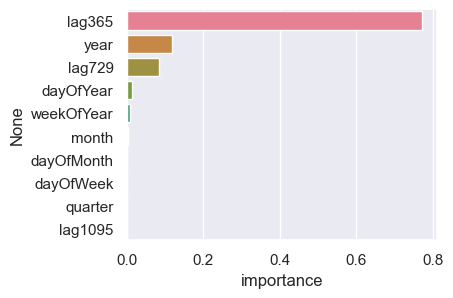

In [78]:
# Plot the feature importance of the model
feat_importance = pd.DataFrame(model.feature_importances_, index = model.feature_names_in_, columns = ['importance'])\
                    .sort_values(by = 'importance', ascending = False)
display(feat_importance)
plt.figure(figsize = (4, 3))
sns.barplot(x = feat_importance['importance'], y = feat_importance.index, palette = 'husl', ci = 0)

In [79]:
# Get the start date for the future data
start_date = str(new_data.index.max())[:10]
start_date

'2024-01-31'

In [82]:
future = pd.DataFrame(index = pd.date_range(start_date, '2024-07-01', freq = 'D')) # --- Create a dataframe with future date
future = add_extra_features(future) # -------------------------------------------------- Add the extra features function
future = pd.concat([new_data, future]) # ------------------------------------------------- Join the future data and old data along row axis
future = add_lag(future) # ------------------------------------------------------------- Add lag features for this new data for prediction
future

,Close,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
2019-01-02,39.480000,1,2019,1,2,2,2,1,NaN,NaN,NaN
2019-01-03,35.547501,1,2019,1,3,3,3,1,NaN,NaN,NaN
2019-01-04,37.064999,1,2019,1,4,4,4,1,NaN,NaN,NaN
2019-01-07,36.982498,1,2019,2,0,7,7,1,NaN,NaN,NaN
2019-01-08,37.687500,1,2019,2,1,8,8,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-27,NaN,6,2024,26,3,27,179,2,158.929993,142.809998,72.267502
2024-06-28,NaN,6,2024,26,4,28,180,2,160.250000,141.509995,73.290001
2024-06-29,NaN,6,2024,26,5,29,181,2,158.279999,140.910004,74.389999
2024-06-30,NaN,6,2024,26,6,30,182,2,157.649994,143.759995,75.157501


In [87]:
# We will predict only the future date aspect of the dataframe that is not in the original dataframe.
# This is to ensure that none of the prediction data was previously used to train the model
# Hence we select the dates that are higher than the future dataframe's start date
future = future.loc[future.index > start_date]
future

,Close,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
2024-02-01,NaN,2,2024,5,3,1,32,1,167.570007,121.029999,56.147499
2024-02-02,NaN,2,2024,5,4,2,33,1,167.229996,123.989998,54.740002
2024-02-03,NaN,2,2024,5,5,3,34,1,167.529999,125.570000,55.205002
2024-02-04,NaN,2,2024,5,6,4,35,1,170.029999,124.760002,56.752499
2024-02-05,NaN,2,2024,6,0,5,36,1,163.619995,120.529999,56.764999
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-27,NaN,6,2024,26,3,27,179,2,158.929993,142.809998,72.267502
2024-06-28,NaN,6,2024,26,4,28,180,2,160.250000,141.509995,73.290001
2024-06-29,NaN,6,2024,26,5,29,181,2,158.279999,140.910004,74.389999
2024-06-30,NaN,6,2024,26,6,30,182,2,157.649994,143.759995,75.157501


In [84]:
# Create a plot for plotting the actual and prediction
def actual_and_pred(actual, prediction):
    fig, axs = plt.subplots(figsize = (12, 4), sharex = True)
    actual.plot(ax = axs,
                      label = 'Original Data',
                      title = "TimeSeries Actual and Prediction Plot")
    prediction.plot(ax = axs,
                     label = 'Prediction')
    axs.axvline(prediction.index.min(), color = 'black', ls = '--')
    plt.legend()

In [88]:
new_data.shape

(1279, 11)

In [89]:
# Predict Existing Data.
# Pls Note that the model will drop in accuracy the further the forecast horizon.
test_table = new_data.iloc[1100:] # ------------- predict only 300+ rows

def predictor(data, response_variable):
    data['predict'] = model.predict(data.drop(response_variable, axis = 1))
    return data

predictor(test_table, 'Close')

,Close,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095,predict
Date,,,,,,,,,,,,
2023-05-16,172.070007,5,2023,20,1,16,136,2,163.759995,90.014999,37.500000,125.667816
2023-05-17,172.690002,5,2023,20,2,17,137,2,161.839996,91.209999,38.267502,125.012070
2023-05-18,175.050003,5,2023,20,3,18,138,2,165.320007,88.407501,38.735001,125.106873
2023-05-19,175.160004,5,2023,20,4,19,139,2,171.179993,90.445000,38.965000,124.966965
2023-05-22,174.199997,5,2023,21,0,22,142,2,175.080002,91.199997,39.205002,126.849495
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-25,194.169998,1,2024,4,3,25,25,1,172.100006,120.129997,54.680000,130.972321
2024-01-26,192.419998,1,2024,4,4,26,26,1,173.190002,121.419998,54.419998,130.487701
2024-01-29,191.729996,1,2024,5,0,29,29,1,173.029999,116.360001,55.257500,129.527161


In [90]:
# Predict Future Data
predictor(future, 'Close')

,Close,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095,predict
2024-02-01,NaN,2,2024,5,3,1,32,1,167.570007,121.029999,56.147499,127.015251
2024-02-02,NaN,2,2024,5,4,2,33,1,167.229996,123.989998,54.740002,126.968323
2024-02-03,NaN,2,2024,5,5,3,34,1,167.529999,125.570000,55.205002,125.778397
2024-02-04,NaN,2,2024,5,6,4,35,1,170.029999,124.760002,56.752499,127.401993
2024-02-05,NaN,2,2024,6,0,5,36,1,163.619995,120.529999,56.764999,127.531158
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-27,NaN,6,2024,26,3,27,179,2,158.929993,142.809998,72.267502,125.035004
2024-06-28,NaN,6,2024,26,4,28,180,2,160.250000,141.509995,73.290001,125.026703
2024-06-29,NaN,6,2024,26,5,29,181,2,158.279999,140.910004,74.389999,130.073273
2024-06-30,NaN,6,2024,26,6,30,182,2,157.649994,143.759995,75.157501,129.610168


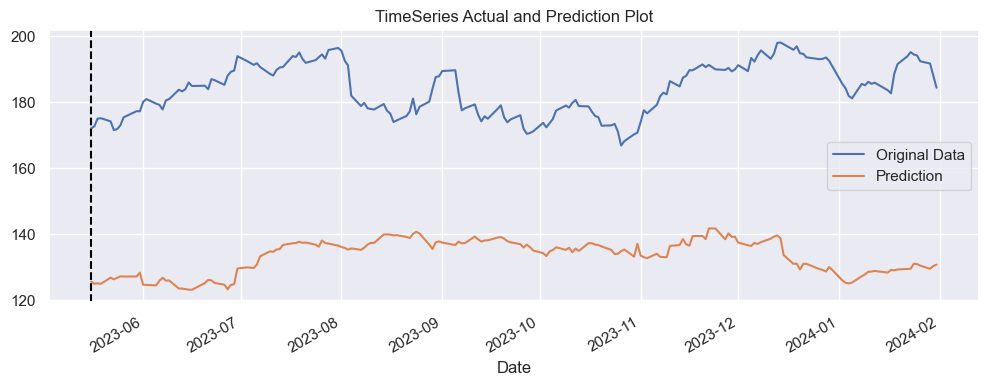

In [91]:
# Plot the actual value and prediction value for present data
actual_and_pred(test_table.Close, test_table.predict)

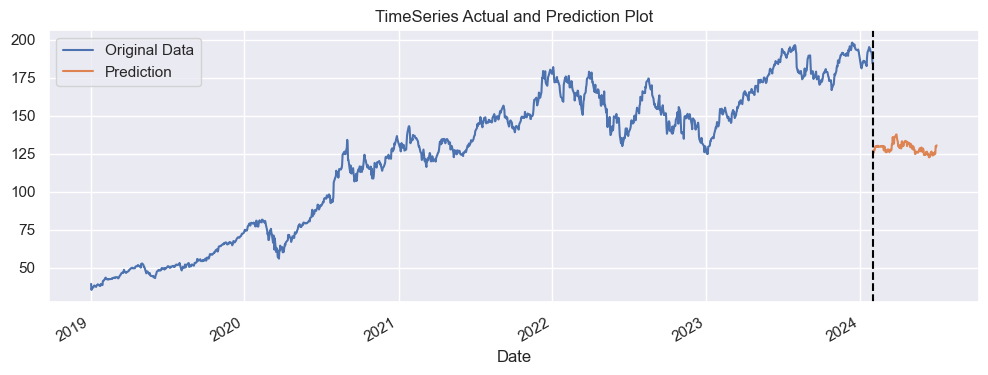

In [95]:
# Plot predicted value for future data
actual_and_pred(new_data['Close'], future.predict)

In [100]:
ticks = ['AAPL (Apple Inc.), MSFT (Microsoft Corporation),AMZN (Amazon.com, Inc.),TSLA (Tesla, Inc.),XOM (ExxonMobil Corporation),JPM (JPMorgan Chase & Co.),V (Visa Inc.),GE (General Electric Company),MON (Monsanto Company),INTC (Intel Corporation),ACB (Canadian Marijuana Companies),AMC (AMC Entertainment Holdings, Inc.),Zoom (Zoom Video Communications, Inc.),TRIP (TripAdvisor Worldwide, Inc.),UZNH (United States Natural Gas Holdings, Inc.),SPE (Royal Dutch Shell A Ltd),Fs(First State Investments),XNJ (ExxonMobil Chemicals Company),BRK-A (Berkshire Hathaway Inc.),LQD (First State Telstra Limited),CSCO (Cisco Systems, Inc.),EXC (ExxonMobil Corporation),WMT (Walmart Inc.),JNJ (Johnson & Johnson),IBM (International Business Machines Corporation),CVS (CVS Health Corporation),DVV (Daimler AG),MNDP (Medtronic, Inc.)']
ticks2 = []
for i in ticks:
    ticks2.append(i.split(','))
ticks2 = ticks2[0]
ticks2

['AAPL (Apple Inc.)',
 ' MSFT (Microsoft Corporation)',
 'AMZN (Amazon.com',
 ' Inc.)',
 'TSLA (Tesla',
 ' Inc.)',
 'XOM (ExxonMobil Corporation)',
 'JPM (JPMorgan Chase & Co.)',
 'V (Visa Inc.)',
 'GE (General Electric Company)',
 'MON (Monsanto Company)',
 'INTC (Intel Corporation)',
 'ACB (Canadian Marijuana Companies)',
 'AMC (AMC Entertainment Holdings',
 ' Inc.)',
 'Zoom (Zoom Video Communications',
 ' Inc.)',
 'TRIP (TripAdvisor Worldwide',
 ' Inc.)',
 'UZNH (United States Natural Gas Holdings',
 ' Inc.)',
 'SPE (Royal Dutch Shell A Ltd)',
 'Fs(First State Investments)',
 'XNJ (ExxonMobil Chemicals Company)',
 'BRK-A (Berkshire Hathaway Inc.)',
 'LQD (First State Telstra Limited)',
 'CSCO (Cisco Systems',
 ' Inc.)',
 'EXC (ExxonMobil Corporation)',
 'WMT (Walmart Inc.)',
 'JNJ (Johnson & Johnson)',
 'IBM (International Business Machines Corporation)',
 'CVS (CVS Health Corporation)',
 'DVV (Daimler AG)',
 'MNDP (Medtronic',
 ' Inc.)']

In [101]:
def data_collector(ticker_symbol):
    stock_data = yf.download(ticker_symbol, start = '2021-03-04', end = '2023-04-04')
    return stock_data

data = data_collector('AAPL')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-04,121.750000,123.599998,118.620003,120.129997,118.070953,178155000
2021-03-05,120.980003,121.940002,117.570000,121.419998,119.338837,153766600
2021-03-08,120.930000,121.000000,116.209999,116.360001,114.365547,154376600
2021-03-09,119.029999,122.059998,118.790001,121.089996,119.014511,129525800
2021-03-10,121.690002,122.169998,119.449997,119.980003,117.923523,111943300
...,...,...,...,...,...,...
2023-03-28,157.970001,158.490005,155.979996,157.649994,156.812973,45992200
2023-03-29,159.369995,161.050003,159.350006,160.770004,159.916428,51305700
2023-03-30,161.529999,162.470001,161.270004,162.360001,161.497971,49501700


In [103]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [104]:
df.index = pd.to_datetime(df.index)

In [108]:
print("Shape of x_train:", x_train.shape)

NameError: name 'x_train' is not defined